In [1]:
import pandas
import numpy as np
import tensorflow as tf
import os
import math
import random as rand
from random import random

# Data Preparation

In [2]:
trainDataFile = 'ijcnlp_dailydialog/train/dialogues_train.txt'
trainLabelsFile = 'ijcnlp_dailydialog/train/dialogues_act_train.txt' 

In [3]:
testDataFile = 'ijcnlp_dailydialog/validation/dialogues_validation.txt'
testLablesFile = 'ijcnlp_dailydialog/validation/dialogues_act_validation.txt'

In [4]:
lineSeparator = '__eou__'

In [5]:
def getData(dialogueFile, labelFile):
    with open(dialogueFile) as f:
        lines = f.readlines() 
    with open(labelFile) as f:
        labels = f.readlines()    
    
    inputs = []
    inputs_all = []
    for line in lines:
        line = line.rstrip()
        line = line.split(lineSeparator)
        inputs.append(line[:-1])
        inputs_all.extend(line[:-1])
    
    acts = []
    acts_all = []
    for label in labels:
        label = label.rstrip()
        label = label.split()
        label = np.array(map(int, label)) - 1
        acts.append(label)
        acts_all.extend(label)
        
    return (inputs_all, inputs, acts_all, acts)

In [6]:
trainX_all, trainX_data, trainY_all, trainY = getData(trainDataFile, trainLabelsFile)
_, valX_data, valY_all, valY = getData(testDataFile, testLablesFile)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vect = CountVectorizer()
trainX_vocab = count_vect.fit(trainX_all)
vocab_dict = trainX_vocab.vocabulary_

# Might want to create a global vocabulary!!

In [8]:
def create_word_embed(vocab_dict, unknown_token, pad_token, embed_size = 300, embed_path = None):
    vocab_emb = dict()
    key_list = vocab_dict.keys()
    if embed_path is not None and os.path.isfile(embed_path):
        # Write some code for creating embeddings from trained embeddings
        miss_count = 0;
        print('Something needs to be done here')
        with open(embed_path) as f:
            embeddings_index = {}
            for line in f:
                values = line.split(' ')
                word = values[0]
                embedding = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = embedding
        for i in key_list:
            if i in embeddings_index:
                vocab_emb[i] = embeddings_index[i]
            else:
                vocab_emb[i] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
                miss_count += 1
        print('Missing Embeddings count: ', miss_count)
        del embeddings_index
    else:
        for i in key_list:
            vocab_emb[i] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
    vocab_emb[unknown_token] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
    vocab_emb[pad_token] = np.array(np.random.uniform(-1.0, 1.0, embed_size))
    return vocab_emb
            

In [9]:
embed_size = 300;
pad_token = '<pad>'
unknown_token = '<unk>'
embed_path = '/Users/abhishekjindal/Downloads/glove.840B.300d.txt'
word_emb = create_word_embed(vocab_dict, unknown_token, pad_token, embed_size, embed_path)
sent_embed_size = embed_size

Something needs to be done here
('Missing Embeddings count: ', 482)


In [10]:
def create_sentence_embed(sentence, word_emb, embed_size, unknown_token, pad_token, calc_mean = True):
    sent_emb = np.zeros(embed_size)
    if calc_mean == False:
        print('What can I do now!!')
    else:
        sent_set = set(sentence.lower().split())
        unk_index = 0;
        count = 0;
        for i in sent_set:
            if i in word_emb:
                sent_emb += word_emb[i]
                count += 1
            else:
                unk_index = 1
        if unk_index:
            sent_emb += word_emb[unknown_token]
        sent_emb = sent_emb / (count + unk_index)
    return sent_emb

# Train a classifier

In [11]:
# Parameters used.
MODEL_PATH = './model_crf_v3.ckpt'

In [12]:
def get_sequence_length(x_data):
    seq = [];
    for i in range(len(x_data)):
        seq.append(len(x_data[i]))
    return seq

In [13]:
x_train = trainX_data
y_train = trainY

x_test = valX_data
y_test = valY

sequence_length_train = get_sequence_length(x_train)
sequence_length_test = get_sequence_length(x_test)


In [14]:
learning_rate = 0.05
#training_epochs = 7
input_size = sent_embed_size
#batch_size = 25
#num_units = 128 # the number of units in the LSTM cell
number_of_classes = len(set(trainY_all))

In [15]:
def pad_data(sentence, max_length, input_size):
    sent_emb = np.array([create_sentence_embed(x, word_emb, embed_size, unknown_token, pad_token, calc_mean = True) for x in sentence])
    pad_len = max_length - len(sentence)
    temp = sent_emb
    if pad_len > 0:
        single_pad = np.zeros(input_size)
        padding = [single_pad] * pad_len
        temp = np.concatenate((sent_emb, padding))
    return temp

In [16]:
def pad_label(sentence, max_length):
    pad_len = max_length - len(sentence)
    padding = np.zeros(pad_len, dtype=int)
    return np.concatenate((sentence, padding))

In [17]:
def batch(data, labels, sequence_lengths, batch_size, input_size):
    n_batch = int(math.ceil(float(len(data)) / (batch_size)))
    index = 0
    for _ in range(n_batch):
        batch_sequence_lengths = np.array(sequence_lengths[index: index + batch_size])
        batch_length = np.array(max(batch_sequence_lengths)) # max length in batch
        batch_data = np.array([pad_data(x, batch_length, input_size) for x in data[index: index + batch_size]]) # pad data
        batch_labels = np.array([pad_label(x, batch_length) for x in labels[index: index + batch_size]]) # pad labels
        index += batch_size
        
        # Reshape input data to be suitable for LSTMs.
        batch_data = batch_data.reshape(-1, batch_length, input_size)
        
        yield batch_data, batch_labels, batch_length, batch_sequence_lengths

In [18]:
input_data = tf.placeholder(tf.float32, [None, None, input_size], name="input_data") # shape = (batch, batch_seq_len, input_size)
labels = tf.placeholder(tf.int32, shape=[None, None], name="labels") # shape = (batch, sentence)
batch_sequence_length = tf.placeholder(tf.int32) # max sequence length in batch
original_sequence_lengths = tf.placeholder(tf.int32, [None])


In [19]:
weights = tf.get_variable("weights", [input_size, number_of_classes])
matricized_x_train = tf.reshape(input_data, [-1, input_size])
matricized_unary_scores = tf.matmul(matricized_x_train, weights)
#matricized_unary_scores = tf.sigmoid(matricized_unary_scores_temp)
scores = tf.reshape(matricized_unary_scores, [-1, batch_sequence_length, number_of_classes])
#scores = tf.reshape(matricized_unary_scores, [num_examples, num_words, num_tags])


In [20]:
# Linear-CRF.
log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(scores, labels, original_sequence_lengths)

loss = tf.reduce_mean(-log_likelihood)

# Compute the viterbi sequence and score (used for prediction and test time).
viterbi_sequence, viterbi_score = tf.contrib.crf.crf_decode(scores, transition_params, original_sequence_lengths)

# Training ops.
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

/Users/abhishekjindal/anaconda3/envs/Python27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
training_epochs = 50;
batch_size = 800
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for i in range(training_epochs):
        for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
            tf_viterbi_sequence, _ = session.run([viterbi_sequence, train_op], 
                                                 feed_dict={input_data: batch_data, 
                                                            labels: batch_labels, 
                                                            batch_sequence_length: batch_seq_len,
                                                            original_sequence_lengths: batch_sequence_lengths })
            # Show train accuracy.
            if i % 1 == 0:
                # Create a mask to fix input lengths.
                mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
                    np.expand_dims(batch_sequence_lengths, axis=1))
                total_labels = np.sum(batch_sequence_lengths)
                correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print("Epoch: %d" % i, "Accuracy: %.2f%%" % accuracy)
    
    # Save the variables to disk.
    saver.save(session, MODEL_PATH)

('Epoch: 0', 'Accuracy: 17.19%')
('Epoch: 0', 'Accuracy: 29.38%')
('Epoch: 0', 'Accuracy: 56.50%')
('Epoch: 0', 'Accuracy: 54.02%')
('Epoch: 0', 'Accuracy: 54.25%')
('Epoch: 0', 'Accuracy: 53.19%')
('Epoch: 0', 'Accuracy: 32.53%')
('Epoch: 0', 'Accuracy: 29.72%')
('Epoch: 0', 'Accuracy: 32.15%')
('Epoch: 0', 'Accuracy: 37.81%')
('Epoch: 0', 'Accuracy: 38.72%')
('Epoch: 0', 'Accuracy: 40.13%')
('Epoch: 0', 'Accuracy: 43.80%')
('Epoch: 0', 'Accuracy: 50.29%')
('Epoch: 1', 'Accuracy: 61.20%')
('Epoch: 1', 'Accuracy: 61.59%')
('Epoch: 1', 'Accuracy: 61.73%')
('Epoch: 1', 'Accuracy: 61.10%')
('Epoch: 1', 'Accuracy: 63.13%')
('Epoch: 1', 'Accuracy: 61.66%')
('Epoch: 1', 'Accuracy: 50.56%')
('Epoch: 1', 'Accuracy: 52.13%')
('Epoch: 1', 'Accuracy: 50.84%')
('Epoch: 1', 'Accuracy: 53.21%')
('Epoch: 1', 'Accuracy: 55.77%')
('Epoch: 1', 'Accuracy: 55.40%')
('Epoch: 1', 'Accuracy: 56.21%')
('Epoch: 1', 'Accuracy: 56.27%')
('Epoch: 2', 'Accuracy: 62.08%')
('Epoch: 2', 'Accuracy: 63.67%')
('Epoch: 2

('Epoch: 17', 'Accuracy: 60.05%')
('Epoch: 17', 'Accuracy: 61.12%')
('Epoch: 17', 'Accuracy: 64.19%')
('Epoch: 17', 'Accuracy: 65.53%')
('Epoch: 17', 'Accuracy: 63.56%')
('Epoch: 17', 'Accuracy: 65.82%')
('Epoch: 18', 'Accuracy: 71.40%')
('Epoch: 18', 'Accuracy: 69.76%')
('Epoch: 18', 'Accuracy: 70.82%')
('Epoch: 18', 'Accuracy: 70.92%')
('Epoch: 18', 'Accuracy: 71.39%')
('Epoch: 18', 'Accuracy: 69.95%')
('Epoch: 18', 'Accuracy: 61.79%')
('Epoch: 18', 'Accuracy: 64.12%')
('Epoch: 18', 'Accuracy: 60.07%')
('Epoch: 18', 'Accuracy: 61.04%')
('Epoch: 18', 'Accuracy: 64.41%')
('Epoch: 18', 'Accuracy: 65.60%')
('Epoch: 18', 'Accuracy: 63.50%')
('Epoch: 18', 'Accuracy: 65.92%')
('Epoch: 19', 'Accuracy: 71.32%')
('Epoch: 19', 'Accuracy: 69.51%')
('Epoch: 19', 'Accuracy: 70.87%')
('Epoch: 19', 'Accuracy: 71.02%')
('Epoch: 19', 'Accuracy: 71.38%')
('Epoch: 19', 'Accuracy: 69.99%')
('Epoch: 19', 'Accuracy: 61.79%')
('Epoch: 19', 'Accuracy: 64.12%')
('Epoch: 19', 'Accuracy: 60.14%')
('Epoch: 19', 

('Epoch: 34', 'Accuracy: 65.95%')
('Epoch: 34', 'Accuracy: 63.80%')
('Epoch: 34', 'Accuracy: 66.52%')
('Epoch: 35', 'Accuracy: 71.78%')
('Epoch: 35', 'Accuracy: 69.09%')
('Epoch: 35', 'Accuracy: 70.24%')
('Epoch: 35', 'Accuracy: 71.71%')
('Epoch: 35', 'Accuracy: 71.96%')
('Epoch: 35', 'Accuracy: 70.38%')
('Epoch: 35', 'Accuracy: 62.16%')
('Epoch: 35', 'Accuracy: 64.70%')
('Epoch: 35', 'Accuracy: 60.26%')
('Epoch: 35', 'Accuracy: 61.04%')
('Epoch: 35', 'Accuracy: 65.14%')
('Epoch: 35', 'Accuracy: 65.97%')
('Epoch: 35', 'Accuracy: 63.77%')
('Epoch: 35', 'Accuracy: 66.52%')
('Epoch: 36', 'Accuracy: 71.78%')
('Epoch: 36', 'Accuracy: 69.07%')
('Epoch: 36', 'Accuracy: 70.17%')
('Epoch: 36', 'Accuracy: 71.62%')
('Epoch: 36', 'Accuracy: 72.01%')
('Epoch: 36', 'Accuracy: 70.45%')
('Epoch: 36', 'Accuracy: 62.17%')
('Epoch: 36', 'Accuracy: 64.65%')
('Epoch: 36', 'Accuracy: 60.25%')
('Epoch: 36', 'Accuracy: 61.08%')
('Epoch: 36', 'Accuracy: 65.07%')
('Epoch: 36', 'Accuracy: 65.97%')
('Epoch: 36', 

In [24]:
# Testing the model.
with tf.Session() as session:
    # Restore variables from disk.
    saver.restore(session, MODEL_PATH)
    
    for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_test, y_test, sequence_length_test, len(x_test), input_size):
        tf_viterbi_sequence = session.run(viterbi_sequence, feed_dict={input_data: batch_data, 
                                                                       labels: batch_labels, 
                                                                       batch_sequence_length: batch_seq_len,
                                                                       original_sequence_lengths: batch_sequence_lengths })
    # mask to correct input sizes
    mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
        np.expand_dims(batch_sequence_lengths, axis=1))
    total_labels = np.sum(batch_sequence_lengths)
    correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
    accuracy = 100.0 * correct_labels / float(total_labels)
    print("Test accuracy: %.2f%%" % accuracy)

    print("Label:", batch_labels[0].astype(int))    
    print("Pred.:", tf_viterbi_sequence[0])

INFO:tensorflow:Restoring parameters from ./model_crf_v3.ckpt
Test accuracy: 65.84%
('Label:', array([1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0]))
('Pred.:', array([2, 3, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))


# Evaluation

In [23]:
from sklearn import metrics

In [24]:
preds = []
for i in range(len(sequence_length_test)):
    preds.extend(tf_viterbi_sequence[i][:sequence_length_test[i]])

In [25]:
metrics.accuracy_score(valY_all, preds)

0.6287024414425579

In [26]:
print(metrics.classification_report(valY_all, preds))

             precision    recall  f1-score   support

          0       0.64      0.71      0.68      3125
          1       0.65      0.76      0.70      2244
          2       0.64      0.40      0.49      1775
          3       0.49      0.45      0.47       925

avg / total       0.63      0.63      0.62      8069



In [27]:
cmat = metrics.confusion_matrix(valY_all, preds)

In [28]:
cmat.diagonal()/cmat.sum(axis=1)

array([0, 0, 0, 0])

In [29]:
cmat

array([[2224,  423,  236,  242],
       [ 343, 1713,  113,   75],
       [ 538,  396,  717,  124],
       [ 348,  100,   58,  419]])

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import itertools

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
classes = ['inform', 'question', 'directive', 'commisive']

Confusion matrix, without normalization
[[2224  423  236  242]
 [ 343 1713  113   75]
 [ 538  396  717  124]
 [ 348  100   58  419]]


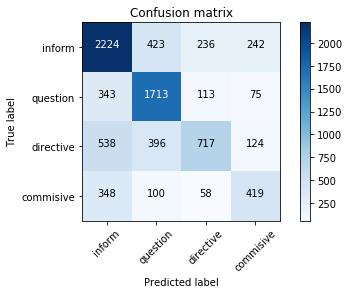

In [34]:
plot_confusion_matrix(cmat, classes)

Normalized confusion matrix
[[0.71168    0.13536    0.07552    0.07744   ]
 [0.15285205 0.76336898 0.05035651 0.03342246]
 [0.30309859 0.22309859 0.40394366 0.06985915]
 [0.37621622 0.10810811 0.0627027  0.45297297]]


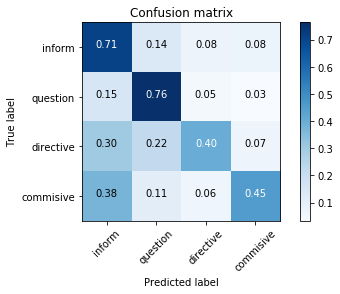

In [35]:
plot_confusion_matrix(cmat, classes, normalize=True)

In [36]:
correctPerClass = {}
totalPerClass   = {}
for cls in [0, 1, 2, 3]:
    correctPerClass[cls] = 0
    totalPerClass[cls]   = 0
for yt, yp in zip(valY_all, preds):
    totalPerClass[yt] += 1
    correctPerClass[yt] += int(yt==yp)



In [37]:
totalPerClass

{0: 3125, 1: 2244, 2: 1775, 3: 925}

In [38]:
correctPerClass

{0: 2224, 1: 1713, 2: 717, 3: 419}

In [39]:
for cls in [0, 1, 2, 3]:
    acc = float(correctPerClass[cls])/totalPerClass[cls]
    print("Accuracy for class ", cls, " :", acc)

('Accuracy for class ', 0, ' :', 0.71168)
('Accuracy for class ', 1, ' :', 0.7633689839572193)
('Accuracy for class ', 2, ' :', 0.40394366197183096)
('Accuracy for class ', 3, ' :', 0.45297297297297295)


# Saving the transition params

In [40]:
x = tf.Variable([[1.0, 2.0], [3, 1]])

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
v = sess.run(transition_params)    

In [41]:
np.savetxt('transition_params_crf_v2.csv', v, delimiter=',')